# Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from tqdm import tqdm
from copy import deepcopy
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Process csv

In [ ]:
# merged_all.csv
!gdown 1eDOBqIQJRLThxFJ2-pg84SfbqlyQWWpp --quiet

# utility.py
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/common/utility.py --quiet

# ids_train.npy
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/common/files/ids_train.npy --quiet

In [ ]:
data_df = pd.read_csv('merged_all.csv')
data_df = data_df.set_index('ID').T

# convert to UTC
new_index = list(pd.to_datetime(data_df.index))
for i in range(len(new_index)):
    new_index[i] = new_index[i] - timedelta(hours=8)
data_df.index = new_index

ids_train = np.load('ids_train.npy')
data_df = data_df.loc[:, ids_train]

data_df

ID                   10001   10003   10004   10008   10009   10010   10011   \
2022-03-20 02:42:00    66.0     4.0    41.0    65.0    37.0    24.0    45.0   
2022-03-20 02:45:00    67.0     3.0    42.0    62.0    37.0    24.0    46.0   
2022-03-20 02:48:00    68.0     2.0    41.0    60.0    35.0    25.0    46.0   
2022-03-20 02:51:00    67.0     1.0    40.0    58.0    35.0    35.0    46.0   
2022-03-20 02:54:00    66.0     1.0    43.0    56.0    33.0    45.0    48.0   
...                     ...     ...     ...     ...     ...     ...     ...   
2022-05-29 15:45:00    24.0     6.0    67.0   105.0    43.0    18.0     4.0   
2022-05-29 15:48:00    24.0     7.0    67.0   105.0    43.0    18.0     4.0   
2022-05-29 15:51:00    24.0     6.0    66.0   105.0    43.0    18.0     4.0   
2022-05-29 15:54:00    24.0     6.0    65.0   106.0    43.0    18.0     4.0   
2022-05-29 15:57:00    24.0     6.0    66.0   106.0    44.0    18.0     4.0   

ID                   10013   10014   10015   ...  180005  200001  210001  \
2022-03-20 02:42:00   390.0     3.0    17.0  ...    79.0    34.0    23.0   
2022-03-20 02:45:00   387.0     4.0    17.0  ...    69.0    34.0    20.0   
2022-03-20 02:48:00   384.0     6.0    17.0  ...    59.0    33.0    21.0   
2022-03-20 02:51:00   382.0     5.0    17.0  ...    57.0    33.0    23.0   
2022-03-20 02:54:00   380.0     6.0    17.0  ...    52.0    32.0    23.0   
...                     ...     ...     ...  ...     ...     ...     ...   
2022-05-29 15:45:00   384.0    38.0    28.0  ...    88.0    39.0    25.0   
2022-05-29 15:48:00   383.0    37.0    28.0  ...    88.0    39.0    25.0   
2022-05-29 15:51:00   382.0    37.0    28.0  ...    88.0    39.0    24.0   
2022-05-29 15:54:00   382.0    38.0    28.0  ...    87.0    39.0    24.0   
2022-05-29 15:57:00   382.0    38.0    28.0  ...    87.0    39.0    24.0   

ID                   210002  230001  230008  230018  260005  270008  290002  
2022-03-20 02:42:00    90.0    12.0     0.0   113.0    42.0     6.0   120.0  
2022-03-20 02:45:00    91.0    11.0     1.0   104.0    42.0    11.0   105.0  
2022-03-20 02:48:00    92.0    12.0     0.0   104.0    42.0     7.0   103.0  
2022-03-20 02:51:00    93.0    11.0     0.0    95.0    42.0     6.0   102.0  
2022-03-20 02:54:00    92.0    11.0     0.0    78.0    42.0     8.0    97.0  
...                     ...     ...     ...     ...     ...     ...     ...  
2022-05-29 15:45:00    51.0    20.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 15:48:00    51.0    20.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 15:51:00    51.0    20.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 15:54:00    51.0    21.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 15:57:00    51.0    21.0   117.0   167.0    23.0    20.0   259.0  

[33578 rows x 250 columns]

In [ ]:
from utility import preprocess
data_df, data_smooth_df = preprocess(data_df)

In [ ]:
from utility import transform
data, ids, times, weekdays, seconds = transform(data_smooth_df)

In [ ]:
from utility import get_valid
is_valid = get_valid(data_smooth_df, no_change_threshold=12)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data.T)
scaler_min = scaler.data_min_
scaler_max = scaler.data_max_
scaler_max[np.isclose(scaler_min, scaler_max)] += 1

np.save('scaler_min', scaler_min)
np.save('scaler_max', scaler_max)

In [ ]:
from utility import scale
data_scaled = scale(data, ids, ids_train, scaler_min, scaler_max)

# Visualize

In [ ]:
# ===== change this =====
id = 10042
# =======================

curr_datetime = data_df.index[0].replace(hour=0, minute=0)
last_datetime = data_df.index[-1]

cnt = 0
while curr_datetime <= last_datetime:
    if cnt % 28 == 0:
        plt.figure(figsize=(25, 15))
    plt.subplot(4, 7, cnt%28+1)
    data_smooth_df.loc[:, id].plot()
    plt.xlim(curr_datetime, curr_datetime.replace(hour=23, minute=59))
    cnt += 1
    curr_datetime += timedelta(days=1)

In [ ]:
# ===== change this =====
index = 10
date = datetime(year=2022, month=4, day=14)
# =======================

ax = data_df.iloc[:, index].plot()
data_smooth_df.iloc[:, index].plot(ax=ax)
plt.xlim(date.replace(hour=0, minute=0), date.replace(hour=23, minute=59))
plt.show()

In [ ]:
last_datetime = data_df.index[-1]
for i in range(data_df.shape[1]):
    plt.figure(figsize=(30, 4))
    for j in range(7):
        plt.subplot(1, 7, 7-j)
        plt.plot(data_df.iloc[:, i])

        valid_data = data_smooth_df.iloc[:, i].copy()
        valid_data[is_valid[i] == False] = np.nan
        invalid_data = data_smooth_df.iloc[:, i].copy()
        invalid_data[is_valid[i] == True] = np.nan
        plt.plot(valid_data)
        plt.plot(invalid_data, color='r')

        curr_datetime = last_datetime - timedelta(days=j)
        start_datetime = curr_datetime.replace(hour=0, minute=0)
        end_datetime = curr_datetime.replace(hour=23, minute=59)
        plt.xlim(start_datetime, end_datetime)

        plt.xticks(rotation=30)
        plt.title(f'lot={data_df.columns[i]}, day={start_datetime.month}/{start_datetime.day}, weekday={start_datetime.weekday()}')
    plt.show()

# Train

## LSTM

In [ ]:
# ParkingModel.py
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/lstm/ParkingModel.py --quiet

# ParkingDataset.py
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/lstm/ParkingDataset.py --quiet

In [ ]:
from ParkingDataset import ParkingDataset

# sanity check
test_sequence = np.array([range(0, 10)])
test_is_valid = np.array([[True, False, True, True, False,
                           True, True, True, True, False]])
test_weekdays = np.arange(10, dtype=int) % 7
test_seconds = np.zeros(10, dtype=int)
print(test_sequence)
print(test_is_valid)
print(test_weekdays)
print(test_seconds)

test_dataset = ParkingDataset(test_sequence, test_is_valid, test_weekdays,
                              test_seconds, predict_len=3)
x_seq, x_extra, y, y_valid = next(iter(test_dataset))
print(x_seq)
print(x_extra)
print(y)
print(y_valid)

[[0 1 2 3 4 5 6 7 8 9]]
[[ True False  True  True False  True  True  True  True False]]
[0 1 2 3 4 5 6 0 1 2]
[0 0 0 0 0 0 0 0 0 0]
tensor([0., 1., 2., 3., 4., 5., 6.])
tensor([[1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.]])
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [3., 4., 5.],
        [4., 5., 6.],
        [5., 6., 7.],
        [6., 7., 8.],
        [7., 8., 9.]])
tensor([[0., 1., 1.],
        [1., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 0.]])


In [ ]:
VAL_LEN = 96 * 7
PREDICT_LEN = 96
BATCH_SIZE = 64

sequence_train = data_scaled[:, :-VAL_LEN]
is_valid_train = is_valid[:, :-VAL_LEN]
weekdays_train = weekdays[:-VAL_LEN]
seconds_train  = seconds[:-VAL_LEN]

sequence_val   = data_scaled[:, -VAL_LEN:]
is_valid_val   = is_valid[:, -VAL_LEN:]
weekdays_val   = weekdays[-VAL_LEN:]
seconds_val    = seconds[-VAL_LEN:]

dataset = {'train': ParkingDataset(sequence_train, is_valid_train, weekdays_train,
                                   seconds_train, PREDICT_LEN),
           'val':   ParkingDataset(sequence_val, is_valid_val, weekdays_val,
                                   seconds_val, PREDICT_LEN)}

dataloader = {'train': DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True),
              'val': DataLoader(dataset['val'], batch_size=BATCH_SIZE, shuffle=True)}

In [ ]:
# sanity check
x_seq, x_extra, y, y_valid = next(iter(dataloader['train']))
print(x_seq.shape)
print(x_extra.shape)
print(y.shape)
print(y_valid.shape)

torch.Size([64, 6006])
torch.Size([64, 6006, 259])
torch.Size([64, 6006, 96])
torch.Size([64, 6006, 96])


In [ ]:
from ParkingModel import ParkingModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
parking_model = ParkingModel(data_scaled.shape[0], PREDICT_LEN).to(device)

epochs = 150
loss_fn = lambda out, y, y_valid : F.mse_loss(out*y_valid, y*y_valid)
optimizer = optim.Adam(parking_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
                                          epochs=epochs, 
                                          steps_per_epoch=len(dataloader['train']))

writer = SummaryWriter()

In [ ]:
loss_min = float('inf')

for epoch in range(epochs):
    print(f'=== epoch {epoch} ===')
    writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch + 1)

    for phase in ['train', 'val']:
        if phase == 'train':
            parking_model.train()
        else:
            parking_model.eval()

        loss_total = 0.0
        for x_seq, x_extra, y, y_valid in tqdm(dataloader[phase]):
            x_seq = x_seq.to(device)
            x_extra = x_extra.to(device)
            y = y.to(device)
            y_valid = y_valid.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                out = parking_model(x_seq, x_extra)
                loss = loss_fn(out, y, y_valid)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            loss_total += loss.item()
        
        loss_avg = loss_total / len(dataloader[phase])
        print(f'{phase}: {loss_avg}')
        writer.add_scalars('Loss', {phase: loss_avg}, epoch + 1)

        if phase == 'val' and loss_avg < loss_min:
            print('loss is lower than previous, saving...')
            loss_min = loss_avg
            best_model_state = deepcopy(parking_model.state_dict())
            best_optim_state = deepcopy(optimizer.state_dict())

    writer.flush()

parking_model.load_state_dict(best_model_state)
optimizer.load_state_dict(best_optim_state)

=== epoch 0 ===


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


train: 0.44248484820127487


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.18759754300117493
loss is lower than previous, saving...
=== epoch 1 ===


100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


train: 0.3815804645419121


100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


val: 0.19294855371117592
=== epoch 2 ===


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


train: 0.33426633477211


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


val: 0.2007574327290058
=== epoch 3 ===


100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


train: 0.292916402220726


100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


val: 0.20769483968615532
=== epoch 4 ===


100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


train: 0.25682733580470085


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.21114175394177437
=== epoch 5 ===


100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


train: 0.2255428433418274


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


val: 0.20530952140688896
=== epoch 6 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.20330942794680595


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


val: 0.1933615393936634
=== epoch 7 ===


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


train: 0.1865040771663189


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


val: 0.18343644216656685
loss is lower than previous, saving...
=== epoch 8 ===


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


train: 0.17490040883421898


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


val: 0.1709926426410675
loss is lower than previous, saving...
=== epoch 9 ===


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


train: 0.16210366785526276


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.15348424389958382
loss is lower than previous, saving...
=== epoch 10 ===


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


train: 0.15063238143920898


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


val: 0.13902832940220833
loss is lower than previous, saving...
=== epoch 11 ===


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


train: 0.1395316980779171


100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


val: 0.1285504586994648
loss is lower than previous, saving...
=== epoch 12 ===


100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


train: 0.128503805026412


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


val: 0.1179048977792263
loss is lower than previous, saving...
=== epoch 13 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.11523464694619179


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


val: 0.10601263120770454
loss is lower than previous, saving...
=== epoch 14 ===


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


train: 0.10469361394643784


100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


val: 0.09493303671479225
loss is lower than previous, saving...
=== epoch 15 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.095121830701828


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.08420869894325733
loss is lower than previous, saving...
=== epoch 16 ===


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


train: 0.08536636643111706


100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


val: 0.07935391366481781
loss is lower than previous, saving...
=== epoch 17 ===


100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


train: 0.07813760824501514


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


val: 0.07604115456342697
loss is lower than previous, saving...
=== epoch 18 ===


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


train: 0.07289242930710316


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


val: 0.07084198202937841
loss is lower than previous, saving...
=== epoch 19 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.06907866336405277


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


val: 0.06664828024804592
loss is lower than previous, saving...
=== epoch 20 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.06670870445668697


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


val: 0.06456939410418272
loss is lower than previous, saving...
=== epoch 21 ===


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


train: 0.06395447440445423


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


val: 0.07007924187928438
=== epoch 22 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.06214355304837227


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


val: 0.06492415722459555
=== epoch 23 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.06088066380470991


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


val: 0.060230836272239685
loss is lower than previous, saving...
=== epoch 24 ===


100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


train: 0.05937037244439125


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


val: 0.05921098403632641
loss is lower than previous, saving...
=== epoch 25 ===


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


train: 0.0631168158724904


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


val: 0.06243565771728754
=== epoch 26 ===


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


train: 0.06002367567270994


100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


val: 0.05508210323750973
loss is lower than previous, saving...
=== epoch 27 ===


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


train: 0.055435316637158394


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


val: 0.05452429410070181
loss is lower than previous, saving...
=== epoch 28 ===


100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


train: 0.05637981649488211


100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


val: 0.052886868827044964
loss is lower than previous, saving...
=== epoch 29 ===


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


train: 0.05344473756849766


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


val: 0.052610100246965885
loss is lower than previous, saving...
=== epoch 30 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.05457022972404957


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


val: 0.06793616712093353
=== epoch 31 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.056978924199938774


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


val: 0.06375743262469769
=== epoch 32 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.05500740651041269


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


val: 0.05701099056750536
=== epoch 33 ===


100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


train: 0.055444021709263325


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.05992498621344566
=== epoch 34 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.054912349209189415


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.05838266294449568
=== epoch 35 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.05840793810784817


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


val: 0.06193494889885187
=== epoch 36 ===


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


train: 0.056198181584477425


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


val: 0.054525500163435936
=== epoch 37 ===


100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


train: 0.053503080271184444


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


val: 0.0543880807235837
=== epoch 38 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.0503065949305892


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.05244746524840593
loss is lower than previous, saving...
=== epoch 39 ===


100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


train: 0.053055222146213055


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


val: 0.048742976039648056
loss is lower than previous, saving...
=== epoch 40 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.05005774088203907


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


val: 0.05094995442777872
=== epoch 41 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.05030769482254982


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


val: 0.05813862103968859
=== epoch 42 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.05038620997220278


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


val: 0.06019268650561571
=== epoch 43 ===


100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


train: 0.054014566354453564


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


val: 0.06413649674504995
=== epoch 44 ===


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


train: 0.058155620470643044


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


val: 0.06593802943825722
=== epoch 45 ===


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


train: 0.05559835024178028


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.04927856009453535
=== epoch 46 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.0495046516880393


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


val: 0.04943577479571104
=== epoch 47 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.051754808984696865


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


val: 0.058906128630042076
=== epoch 48 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.0498490072786808


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


val: 0.04754137713462114
loss is lower than previous, saving...
=== epoch 49 ===


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


train: 0.04710800759494305


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


val: 0.049376435577869415
=== epoch 50 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.044341293163597584


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


val: 0.04648163076490164
loss is lower than previous, saving...
=== epoch 51 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.04495548456907272


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


val: 0.047609767876565456
=== epoch 52 ===


100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


train: 0.045046208426356316


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


val: 0.044654032215476036
loss is lower than previous, saving...
=== epoch 53 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.04406101908534765


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


val: 0.04992279689759016
=== epoch 54 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.04349770117551088


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


val: 0.047170234844088554
=== epoch 55 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.04445625375956297


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


val: 0.047670272178947926
=== epoch 56 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.04749452695250511


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


val: 0.05042204726487398
=== epoch 57 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.04459831677377224


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


val: 0.04430883191525936
loss is lower than previous, saving...
=== epoch 58 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.04634258337318897


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


val: 0.0521875349804759
=== epoch 59 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.04738135635852814


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


val: 0.053399440832436085
=== epoch 60 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.04603977967053652


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


val: 0.04550741985440254
=== epoch 61 ===


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


train: 0.04465286713093519


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


val: 0.04341149888932705
loss is lower than previous, saving...
=== epoch 62 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.04336343426257372


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


val: 0.04581484757363796
=== epoch 63 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.04262333735823631


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.04270376265048981
loss is lower than previous, saving...
=== epoch 64 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.043286923319101334


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


val: 0.053574347868561745
=== epoch 65 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.04674110747873783


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.05367154721170664
=== epoch 66 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.045316643081605434


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


val: 0.046217868104577065
=== epoch 67 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.04542309045791626


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


val: 0.046292793937027454
=== epoch 68 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.04374977946281433


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


val: 0.044362359680235386
=== epoch 69 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.04131800774484873


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.04307825304567814
=== epoch 70 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.041116599924862385


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.042442742735147476
loss is lower than previous, saving...
=== epoch 71 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.043759931810200214


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


val: 0.041192566975951195
loss is lower than previous, saving...
=== epoch 72 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.040366959758102894


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


val: 0.04367454256862402
=== epoch 73 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.04013594798743725


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


val: 0.04159291461110115
=== epoch 74 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.04164666496217251


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


val: 0.0467006778344512
=== epoch 75 ===


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


train: 0.03980029094964266


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


val: 0.043525347486138344
=== epoch 76 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.040468973107635975


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


val: 0.044546944089233875
=== epoch 77 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.04083840921521187


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


val: 0.0475927721709013
=== epoch 78 ===


100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


train: 0.03960978239774704


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.043088894337415695
=== epoch 79 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.038164230063557625


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


val: 0.04144642874598503
=== epoch 80 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.03808010555803776


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


val: 0.040785908699035645
loss is lower than previous, saving...
=== epoch 81 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.03816105145961046


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


val: 0.041699184104800224
=== epoch 82 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.038067251443862915


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


val: 0.04021221771836281
loss is lower than previous, saving...
=== epoch 83 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03801913745701313


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


val: 0.04355571325868368
=== epoch 84 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.04003516677767038


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


val: 0.04165272880345583
=== epoch 85 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03955312259495258


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


val: 0.04216631501913071
=== epoch 86 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.0378473736345768


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


val: 0.03968320041894913
loss is lower than previous, saving...
=== epoch 87 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03993996512144804


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


val: 0.04030420631170273
=== epoch 88 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.038650852628052235


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


val: 0.04290686082094908
=== epoch 89 ===


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


train: 0.0374120082706213


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


val: 0.04012250900268555
=== epoch 90 ===


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


train: 0.03708779625594616


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


val: 0.04007106367498636
=== epoch 91 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.039301889948546886


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


val: 0.03970039449632168
=== epoch 92 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03801947087049484


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


val: 0.04007463902235031
=== epoch 93 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03773987479507923


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


val: 0.039532370865345
loss is lower than previous, saving...
=== epoch 94 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.037400384433567524


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


val: 0.0393932219594717
loss is lower than previous, saving...
=== epoch 95 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03714086767286062


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


val: 0.039749604649841785
=== epoch 96 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.037941317074000835


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


val: 0.03926679026335478
loss is lower than previous, saving...
=== epoch 97 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03917199280112982


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


val: 0.03934889193624258
=== epoch 98 ===


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


train: 0.03828438464552164


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


val: 0.04253481235355139
=== epoch 99 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.038652144372463226


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


val: 0.03998194634914398
=== epoch 100 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.0381589038297534


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


val: 0.0419832831248641
=== epoch 101 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03756208810955286


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


val: 0.04041278921067715
=== epoch 102 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03650099039077759


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.041508360765874386
=== epoch 103 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.038305568508803844


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


val: 0.04056302923709154
=== epoch 104 ===


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


train: 0.03597979713231325


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


val: 0.03947854321449995
=== epoch 105 ===


100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


train: 0.03597802761942148


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.039587716571986675
=== epoch 106 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.0358104333281517


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


val: 0.03983643837273121
=== epoch 107 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.03620277810841799


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


val: 0.03919323533773422
loss is lower than previous, saving...
=== epoch 108 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.035635942593216896


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


val: 0.03928538877516985
=== epoch 109 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03590068966150284


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


val: 0.039287242107093334
=== epoch 110 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.03599920682609081


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


val: 0.039088902063667774
loss is lower than previous, saving...
=== epoch 111 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.035191066563129425


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


val: 0.039267211221158504
=== epoch 112 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.0377271962352097


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


val: 0.03953708428889513
=== epoch 113 ===


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


train: 0.03607581555843353


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.03912298567593098
=== epoch 114 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03658686298877001


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


val: 0.039253621362149715
=== epoch 115 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03594421083107591


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


val: 0.039490098133683205
=== epoch 116 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03534973971545696


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.03910539299249649
=== epoch 117 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.035749287344515324


100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


val: 0.039132047444581985
=== epoch 118 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.03501102328300476


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


val: 0.03947468753904104
=== epoch 119 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.03546920605003834


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


val: 0.03943336009979248
=== epoch 120 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.037377750501036644


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


val: 0.039028797298669815
loss is lower than previous, saving...
=== epoch 121 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.035234663635492325


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


val: 0.03888069000095129
loss is lower than previous, saving...
=== epoch 122 ===


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


train: 0.034551857970654964


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.039176974445581436
=== epoch 123 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.035008867271244526


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


val: 0.03905752394348383
=== epoch 124 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03525327146053314


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


val: 0.03908467944711447
=== epoch 125 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.03450367692857981


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


val: 0.03927100170403719
=== epoch 126 ===


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


train: 0.03550929017364979


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.03868896421045065
loss is lower than previous, saving...
=== epoch 127 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.03491431847214699


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.038799649104475975
=== epoch 128 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03411066811531782


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


val: 0.0392226567491889
=== epoch 129 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.035494504030793905


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


val: 0.039001946337521076
=== epoch 130 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03504498582333326


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.03904715087264776
=== epoch 131 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03553649876266718


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


val: 0.03872599871829152
=== epoch 132 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03464794857427478


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


val: 0.038792907260358334
=== epoch 133 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.034508293494582176


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


val: 0.03868718910962343
loss is lower than previous, saving...
=== epoch 134 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.035460641607642174


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.03890456259250641
=== epoch 135 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03489771857857704


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


val: 0.03890458960086107
=== epoch 136 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03515841346234083


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


val: 0.03891373798251152
=== epoch 137 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.0374966012313962


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


val: 0.03917056694626808
=== epoch 138 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.03421349450945854


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


val: 0.03904536506161094
=== epoch 139 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03627730347216129


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


val: 0.038732195273041725
=== epoch 140 ===


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


train: 0.03405539318919182


100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


val: 0.038912490010261536
=== epoch 141 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03480109013617039


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


val: 0.03887439705431461
=== epoch 142 ===


100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


train: 0.03560945484787226


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


val: 0.03884891979396343
=== epoch 143 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03492290060967207


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


val: 0.038877067156136036
=== epoch 144 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.03495065029710531


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


val: 0.03890644107013941
=== epoch 145 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.03394009964540601


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


val: 0.03887960221618414
=== epoch 146 ===


100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


train: 0.03444278612732887


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


val: 0.038697050884366035
=== epoch 147 ===


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train: 0.034130570478737354


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


val: 0.03892761282622814
=== epoch 148 ===


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


train: 0.0347932418808341


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


val: 0.038784751668572426
=== epoch 149 ===


100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train: 0.035168612375855446


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

val: 0.03895256947726011


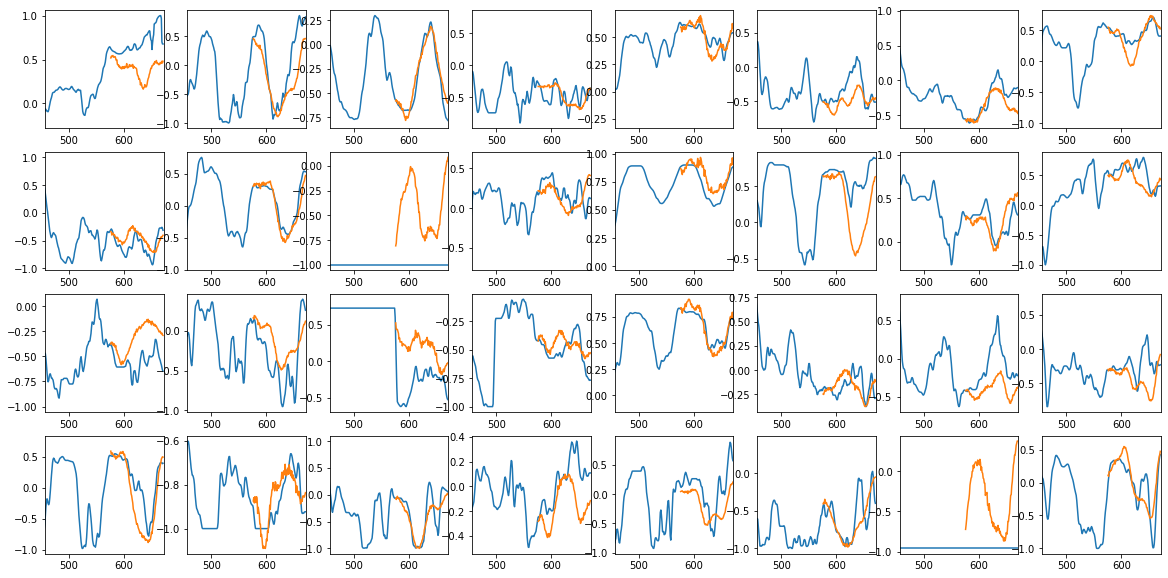

In [ ]:
plt.figure(figsize=(20, 10))

x_seq, x_extra, y, _ = next(iter(dataloader['val']))

x_seq = x_seq.to(device)
x_extra = x_extra.to(device)
y = y.to(device)

parking_model.eval()
out = parking_model(x_seq, x_extra)
ground_truth = torch.concat((x_seq, y[:, -1, :]), dim=1)

pred_start_idx = x_seq.shape[1]
pred_end_idx = pred_start_idx + y.shape[2]

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.plot(ground_truth[i].cpu())
    plt.plot(range(pred_start_idx, pred_end_idx), out[i, -1].detach().cpu())
    plt.xlim(pred_start_idx-120, pred_end_idx)

plt.show()

In [ ]:
torch.save(parking_model.state_dict(), 'parking_model.pt')
print(parking_model.p_lot_len, parking_model.predict_len)

250 96


## Prophet

In [ ]:
!pip install pystan==2.19.1.1 --quiet
!pip install prophet --quiet

     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 45 kB 2.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
from prophet import Prophet
data_smooth_df.values[~is_valid.T] = np.nan
prophet_model = np.empty((250, 3, 96*7))

for i in range(250):
    df = data_df.iloc[:, [i]]
    ID = df.columns[0]
    df = df.reset_index()
    df.columns = ['ds', 'y']

    m = Prophet(growth='flat')
    m.fit(df)

    future_dt = pd.date_range(start='2022-06-13 00:00:00', end='2022-06-19 23:59:57', freq='15min')
    future_df = future_dt.to_frame(name='ds').reset_index(drop=True)

    forecast = m.predict(future_df)

    prophet_model[i, 0] = forecast['yhat']
    prophet_model[i, 1] = forecast['yhat_lower']
    prophet_model[i, 2] = forecast['yhat_upper']

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=Tru

In [ ]:
np.save('prophet_model.npy', prophet_model)

## Average

In [ ]:
only_valid_df = data_smooth_df.copy()
only_valid_df[is_valid.T == False] = np.nan

avg_df = only_valid_df.groupby([only_valid_df.index.dayofweek, only_valid_df.index.time]).mean()
avg_df.index.names = ['weekday', 'time']
avg_df

ID                   10001     10003      10004       10008   10009   \
weekday time                                                           
0       00:00:00  41.874000  8.365000  55.114000   85.283750  58.260   
        00:15:00  45.482000  8.482500  51.892000   78.441250  55.455   
        00:30:00  49.054000  8.441250  48.226000   71.758750  51.475   
        00:45:00  50.182895  8.297336  44.415184   65.602599  47.855   
        01:00:00  50.219579  8.053158  40.857474   59.976118  44.690   
...                     ...       ...        ...         ...     ...   
6       22:45:00  29.046000  7.465000  61.056000  107.686250  61.610   
        23:00:00  31.232000  7.548750  61.134000  106.236250  61.450   
        23:15:00  33.404000  7.788750  60.620000  103.350000  61.320   
        23:30:00  35.266000  7.905000  59.654000   98.365000  61.025   
        23:45:00  38.218000  8.121250  57.898000   91.896250  60.080   

ID                   10010      10011       10013      10014      10015   ...  \
weekday time                                                              ...   
0       00:00:00  47.502000  45.328000  357.108750  28.714286  27.754000  ...   
        00:15:00  48.282000  47.098000  332.021250  22.304286  27.446000  ...   
        00:30:00  49.334000  48.850000  301.098750  14.888571  27.158000  ...   
        00:45:00  49.989684  50.790026  267.274490   8.262763  26.819342  ...   
        01:00:00  50.657158  52.698000  233.321118   4.320902  25.028947  ...   
...                     ...        ...         ...        ...        ...  ...   
6       22:45:00  27.886667  22.223333  397.966250  32.216250  28.558000  ...   
        23:00:00  35.774000  29.980000  398.701250  33.431429  28.372000  ...   
        23:15:00  40.504000  35.322000  396.447500  34.575714  28.240000  ...   
        23:30:00  44.158000  40.028000  390.095000  34.807143  28.194000  ...   
        23:45:00  46.306000  43.382000  376.941250  33.110000  27.984000  ...   

ID                   180005     200001     210001     210002     230001  \
weekday time                                                              
0       00:00:00  95.355000  34.895000  37.617500  69.830000  58.922000   
        00:15:00  94.867500  34.416667  35.856250  72.350000  61.934000   
        00:30:00  94.322500  33.798333  34.550000  73.815000  62.958000   
        00:45:00  93.899753  33.187456  33.546776  75.200921  62.844421   
        01:00:00  93.204276  32.708246  33.231645  76.561053  62.601684   
...                     ...        ...        ...        ...        ...   
6       22:45:00  98.026250  39.416667  30.504444  44.175556  28.646667   
        23:00:00  98.342500  38.528333  34.523750  47.751250  36.510000   
        23:15:00  97.990000  37.286667  36.791250  53.845000  42.234000   
        23:30:00  97.210000  36.286667  38.205000  59.942500  48.500000   
        23:45:00  96.176250  35.555000  38.535000  65.518750  54.452000   

ID                    230008      230018     260005     270008      290002  
weekday time                                                                
0       00:00:00  115.945000  164.125000  36.436250  19.141667  261.401667  
        00:15:00  115.751250  165.000000  37.298750  18.983333  261.293333  
        00:30:00  115.653750  165.110000  38.050000  18.835000  260.866667  
        00:45:00  115.662566  164.750954  38.622253  18.514430  260.244254  
        01:00:00  115.727105  164.257105  39.171250  18.315614  259.326842  
...                      ...         ...        ...        ...         ...  
6       22:45:00  116.464286  167.000000  31.068750  19.450000  257.996667  
        23:00:00  116.427143  167.000000  32.002500  19.710000  258.536667  
        23:15:00  116.342857  164.490000  33.062500  19.720000  259.315000  
        23:30:00  116.198571  164.375000  34.233750  19.642000  260.010000  
        23:45:00  116.151250  164.250000  35.457500  19.391667  260.916667  

[672 rows x 250 columns]

In [ ]:
np.save("average_model.npy", avg_df.to_numpy().T)

# Evaluation

In [ ]:
# change this!
MODEL_TYPE = 'lstm'

In [ ]:
!mkdir tmp
%cd tmp

/content/tmp


In [ ]:
# common
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/common/files/ids_train.npy --quiet
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/common/utility.py --quiet

# lstm
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/lstm/files/scaler_min.npy --quiet
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/lstm/files/scaler_max.npy --quiet
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/lstm/files/parking_model.pt --quiet
!wget https://raw.githubusercontent.com/lashhw/AI-Final-Project/main/azure-functions/models/lstm/ParkingModel.py --quiet

# prophet
!wget https://github.com/lashhw/AI-Final-Project/raw/main/azure-functions/models/prophet/prophet_model.npy --quiet

# average
!wget https://github.com/lashhw/AI-Final-Project/raw/main/azure-functions/models/average/average_model.npy --quiet

# test_data.csv
!gdown 1svkqA-oqh0k5d-4_CDg45ngU7ZJVEytk --quiet

In [ ]:
test_df = pd.read_csv('test_data.csv')
test_df = test_df.set_index('ID').T

# convert to UTC
new_index = list(pd.to_datetime(test_df.index))
for i in range(len(new_index)):
    new_index[i] = new_index[i] - timedelta(hours=8)
test_df.index = new_index

ids_train = np.load('ids_train.npy')
ids_isin = np.isin(ids_train, test_df.columns)
ids_eval = ids_train[ids_isin]

test_df = test_df.loc[:, ids_eval]
test_df

ID                   10001   10003   10004   10008   10009   10010   10011   \
2022-05-29 16:00:00    24.0     6.0    66.0   106.0    44.0    17.0     4.0   
2022-05-29 16:03:00    25.0     6.0    66.0   106.0    44.0    19.0     4.0   
2022-05-29 16:06:00    25.0     6.0    66.0   106.0    45.0    18.0     4.0   
2022-05-29 16:09:00    25.0     6.0    66.0   106.0    45.0    18.0     4.0   
2022-05-29 16:12:00    25.0     5.0    66.0   106.0    45.0    18.0     4.0   
...                     ...     ...     ...     ...     ...     ...     ...   
2022-06-05 15:45:00    22.0    10.0    67.0   106.0    66.0    16.0    22.0   
2022-06-05 15:48:00    21.0    10.0    67.0   105.0    66.0    16.0    22.0   
2022-06-05 15:51:00    21.0    10.0    67.0   105.0    67.0    16.0    22.0   
2022-06-05 15:54:00    21.0    10.0    67.0   105.0    68.0    16.0    22.0   
2022-06-05 15:57:00    21.0     9.0    67.0   105.0    68.0    16.0    22.0   

ID                   10013   10014   10015   ...  180005  200001  210001  \
2022-05-29 16:00:00   382.0    38.0    29.0  ...    87.0    39.0    24.0   
2022-05-29 16:03:00   384.0    38.0    29.0  ...    87.0    39.0    23.0   
2022-05-29 16:06:00   384.0    38.0    31.0  ...    87.0    39.0    23.0   
2022-05-29 16:09:00   386.0    38.0    31.0  ...    87.0    39.0    23.0   
2022-05-29 16:12:00   387.0    38.0    31.0  ...    87.0    39.0    23.0   
...                     ...     ...     ...  ...     ...     ...     ...   
2022-06-05 15:45:00   397.0    44.0    29.0  ...    91.0    38.0    20.0   
2022-06-05 15:48:00   397.0    44.0    29.0  ...    91.0    38.0    21.0   
2022-06-05 15:51:00   397.0    45.0    29.0  ...    91.0    38.0    21.0   
2022-06-05 15:54:00   397.0    45.0    29.0  ...    91.0    38.0    21.0   
2022-06-05 15:57:00   397.0    44.0    29.0  ...    90.0    38.0    21.0   

ID                   210002  230001  230008  230018  260005  270008  290002  
2022-05-29 16:00:00    51.0    21.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 16:03:00    51.0    21.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 16:06:00    51.0    21.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 16:09:00    51.0    21.0   117.0   167.0    23.0    20.0   259.0  
2022-05-29 16:12:00    51.0    20.0   117.0   167.0    23.0    20.0   258.0  
...                     ...     ...     ...     ...     ...     ...     ...  
2022-06-05 15:45:00    49.0    29.0   117.0   159.0    27.0    20.0   260.0  
2022-06-05 15:48:00    48.0    29.0   117.0   159.0    27.0    20.0   260.0  
2022-06-05 15:51:00    48.0    29.0   117.0   159.0    27.0    20.0   260.0  
2022-06-05 15:54:00    48.0    29.0   117.0   159.0    27.0    20.0   260.0  
2022-06-05 15:57:00    48.0    29.0   117.0   159.0    27.0    20.0   261.0  

[3313 rows x 248 columns]

In [ ]:
from ParkingModel import ParkingModel

ids_train = np.load('ids_train.npy')
scaler_min = np.load('scaler_min.npy')
scaler_max = np.load('scaler_max.npy')

lstm_model = ParkingModel(250, 96)
lstm_model.load_state_dict(torch.load('parking_model.pt', map_location=torch.device('cpu')))
lstm_model.eval()

prophet_model = np.load('prophet_model.npy')
average_model = np.load('average_model.npy')

In [ ]:
from utility import lstm_predict, predict_from_numpy

def get_pred(start_idx):
    ground_truth = test_df[[id]].iloc[start_idx:start_idx+480*4]
    input_df = ground_truth.iloc[:-480]

    if MODEL_TYPE == 'lstm':
        pred, pred_times = lstm_predict(input_df, ids_train, scaler_min, 
                                        scaler_max, lstm_model)
        pred_df = pd.DataFrame(pred.T, index=pred_times)
    elif MODEL_TYPE == 'prophet':
        pred, pred_times = predict_from_numpy(id, ids_train, 96, prophet_model,
                                              pred_start=input_df.index[-1])
        pred_df = pd.DataFrame(pred[0], index=pred_times)
    elif MODEL_TYPE == 'average':
        pred, pred_times = predict_from_numpy(id, ids_train, 96, average_model,
                                              pred_start=input_df.index[-1])
        pred_df = pd.DataFrame(pred, index=pred_times)

    indices = np.isin(pred_df.index, ground_truth.index)
    pred_df = pred_df.loc[indices, :]
    diff = pred_df.to_numpy() - ground_truth.loc[pred_df.index, [id]].to_numpy()

    id_idx = np.where(id == ids_train)[0][0]
    diff_scaled = diff / scaler_max[id_idx]
    
    return ground_truth, pred_df, diff, diff_scaled

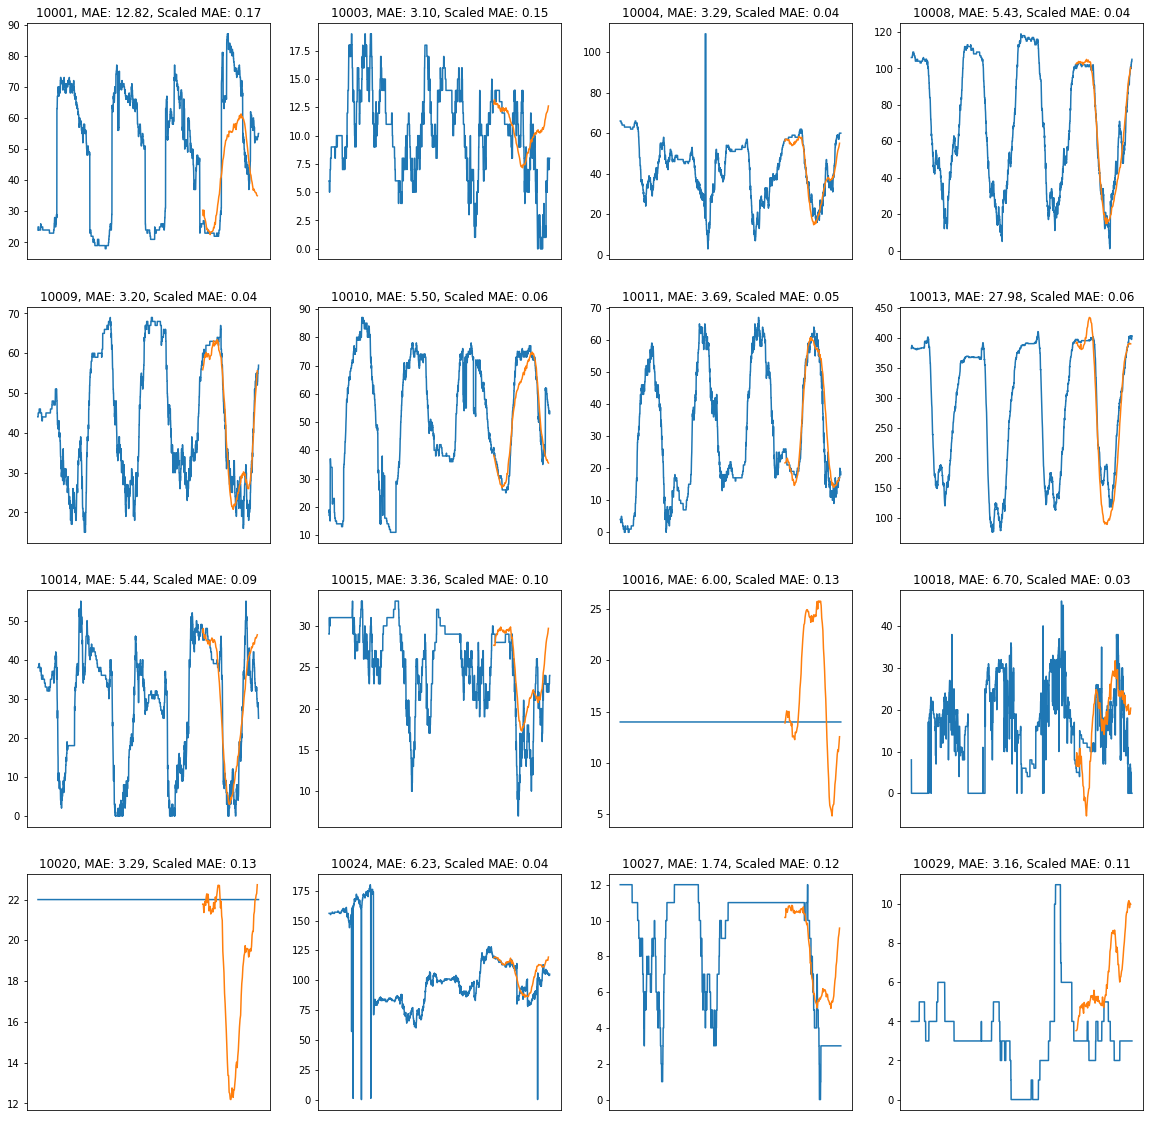

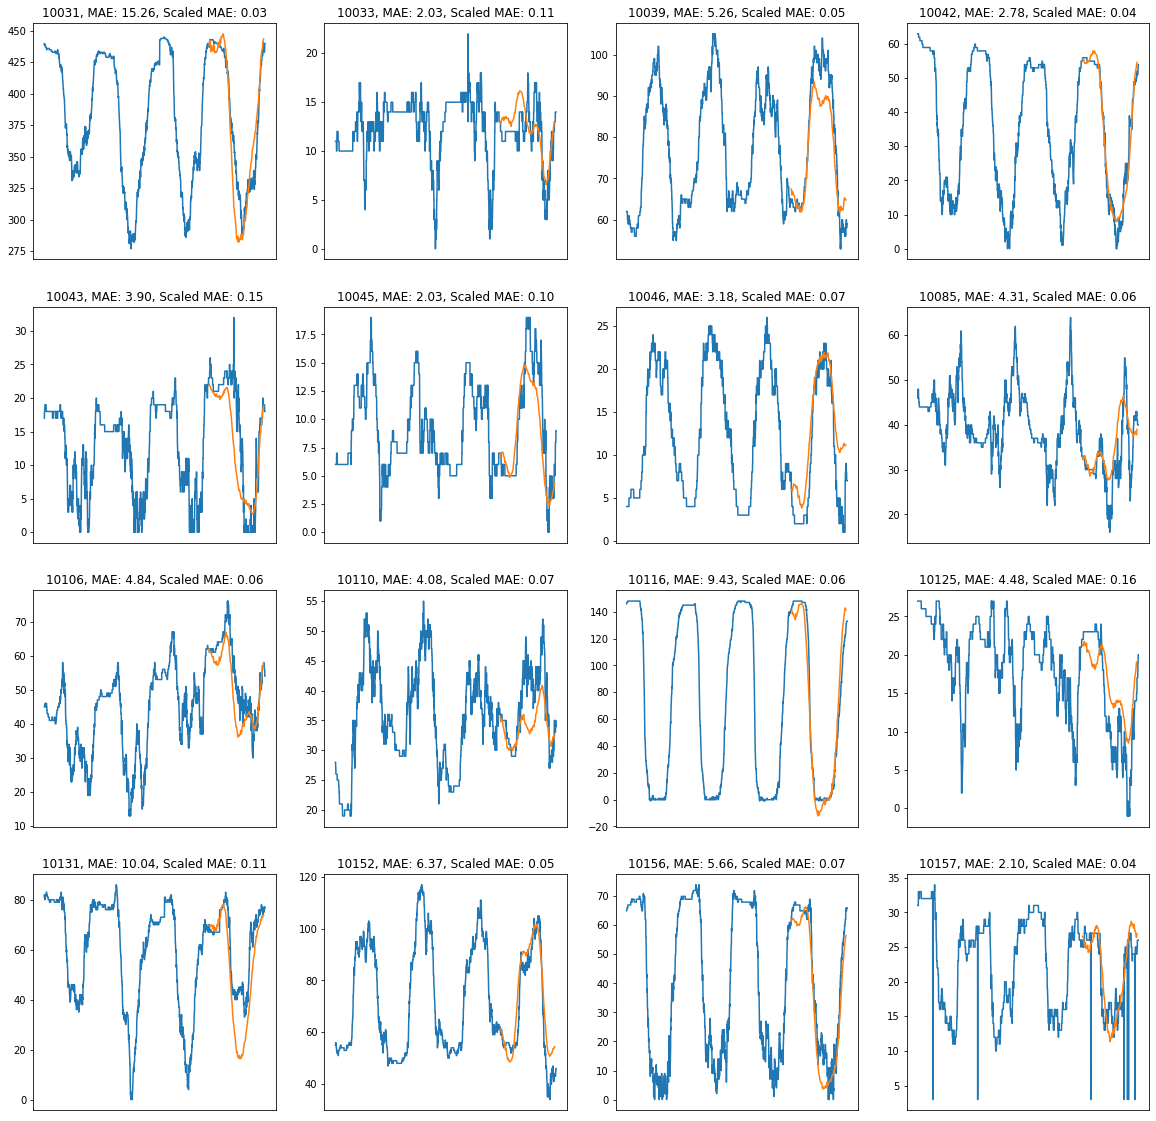

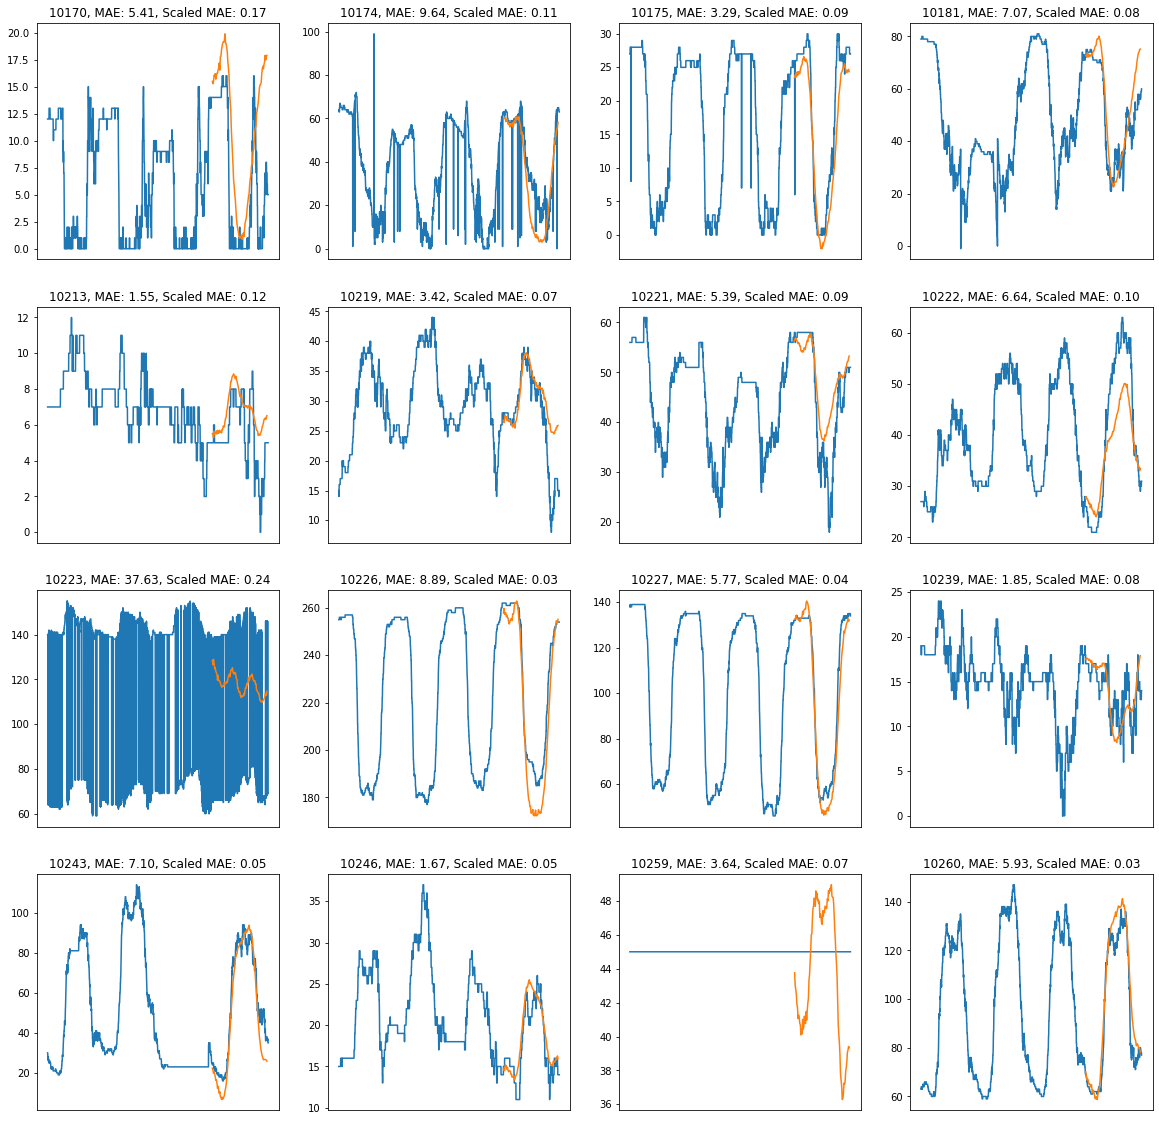

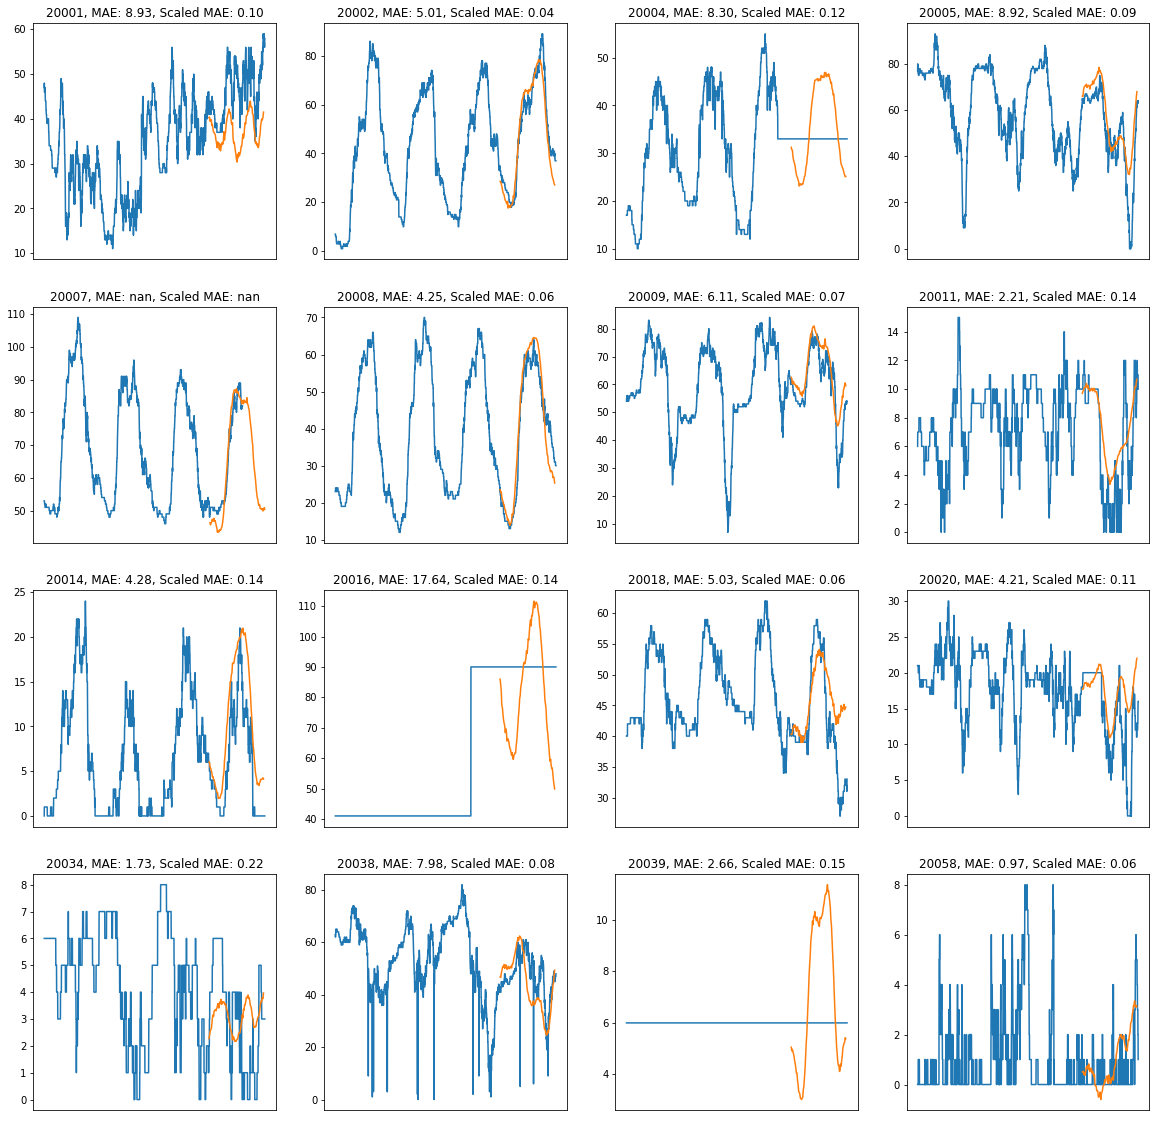

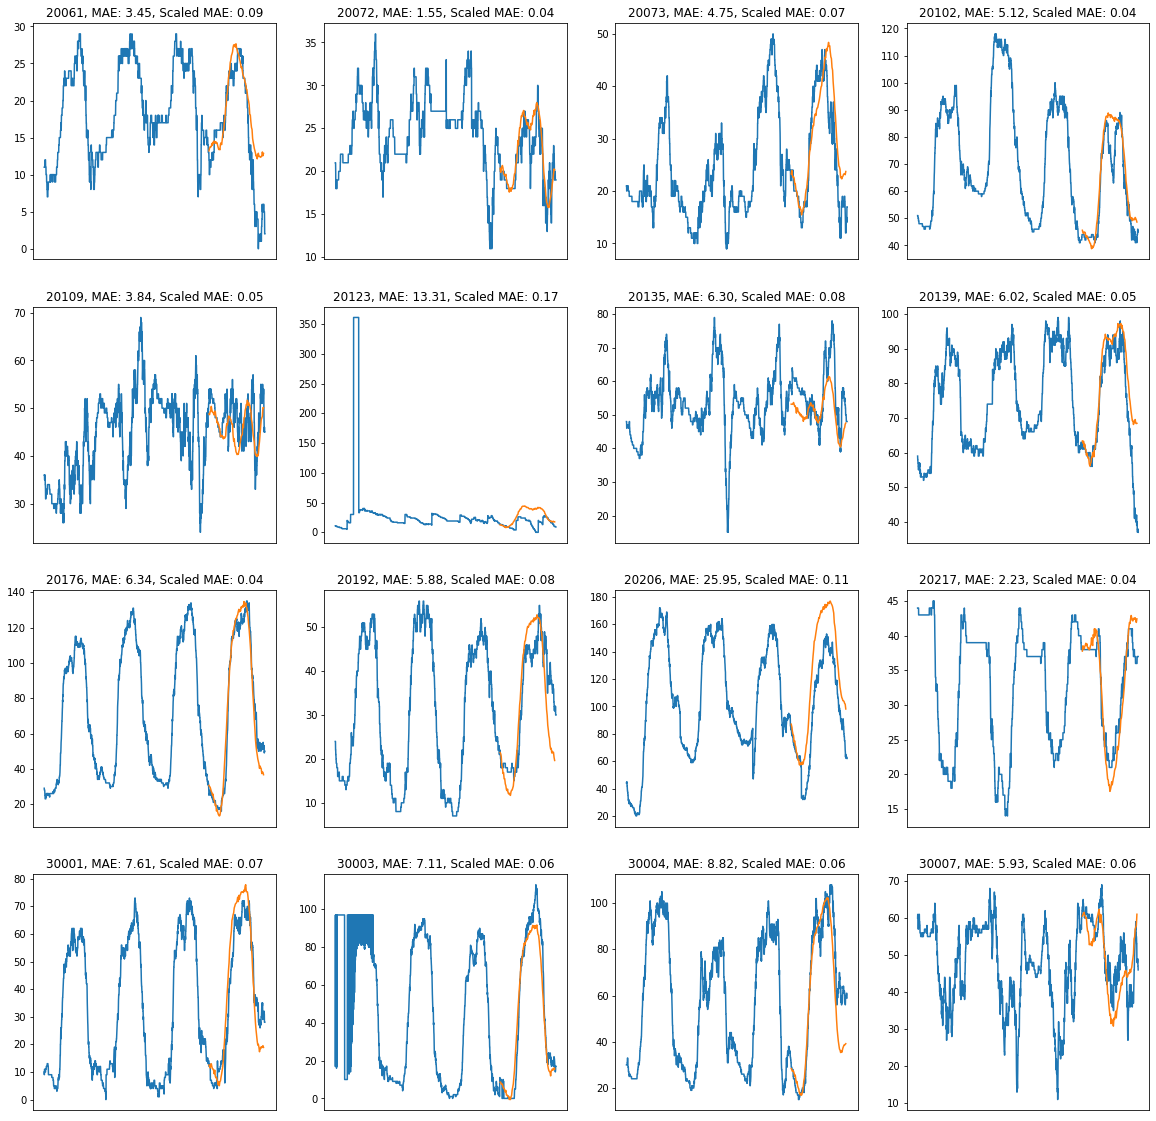

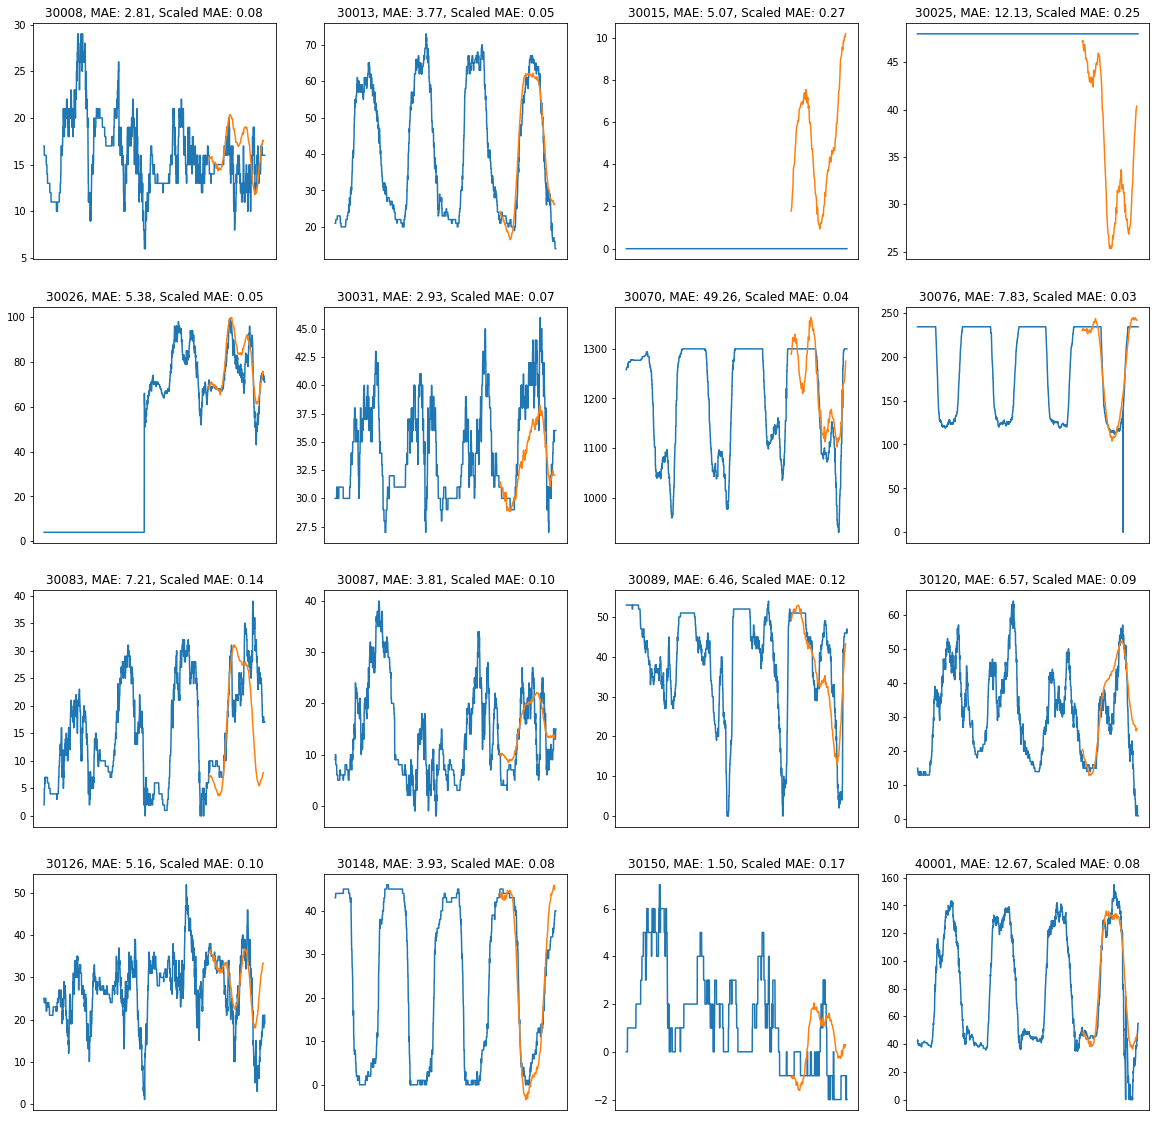

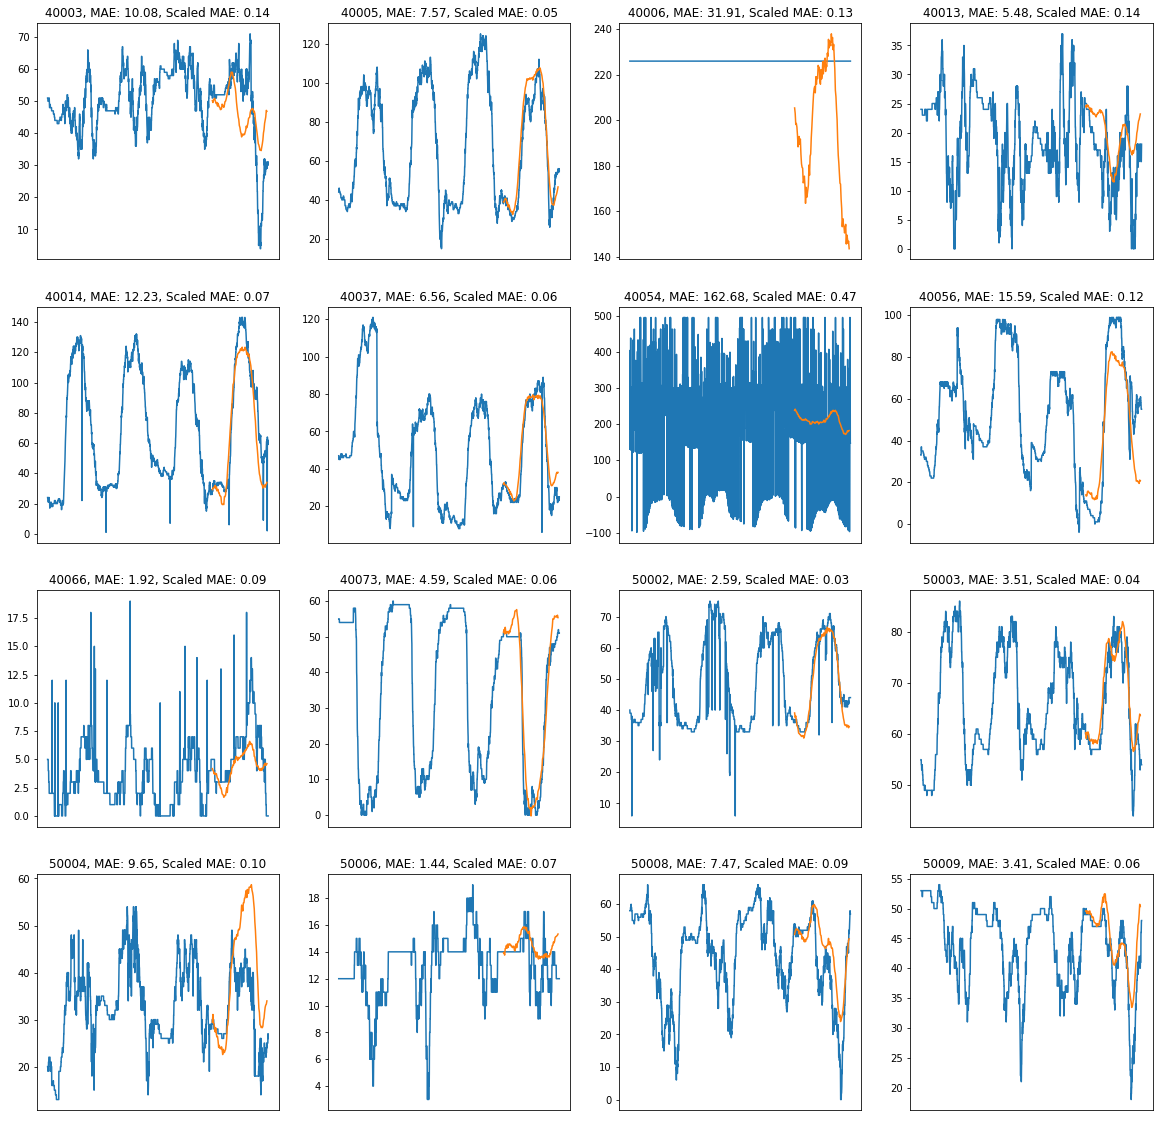

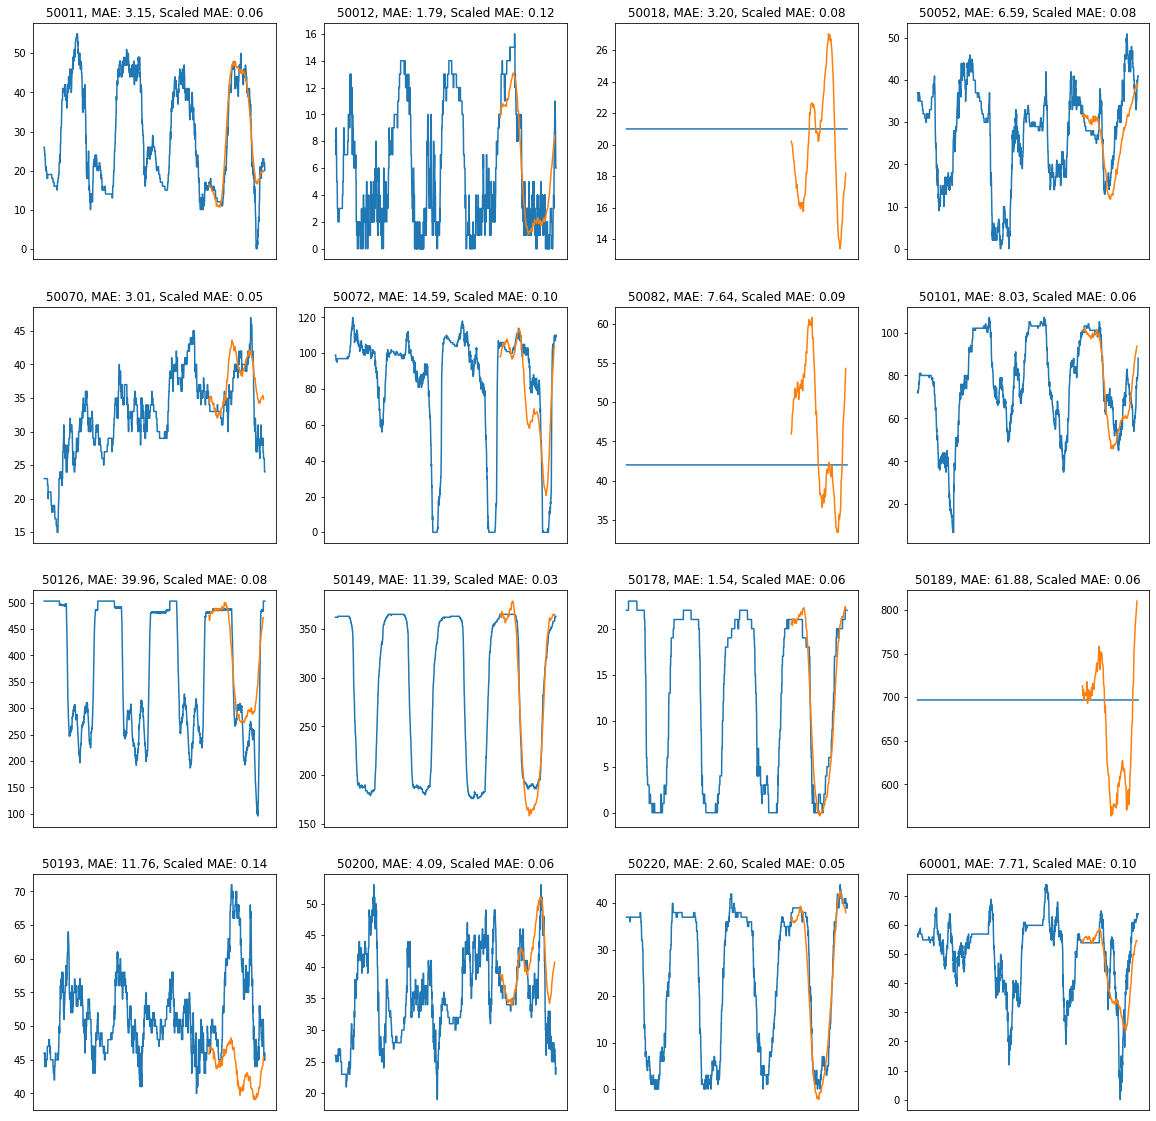

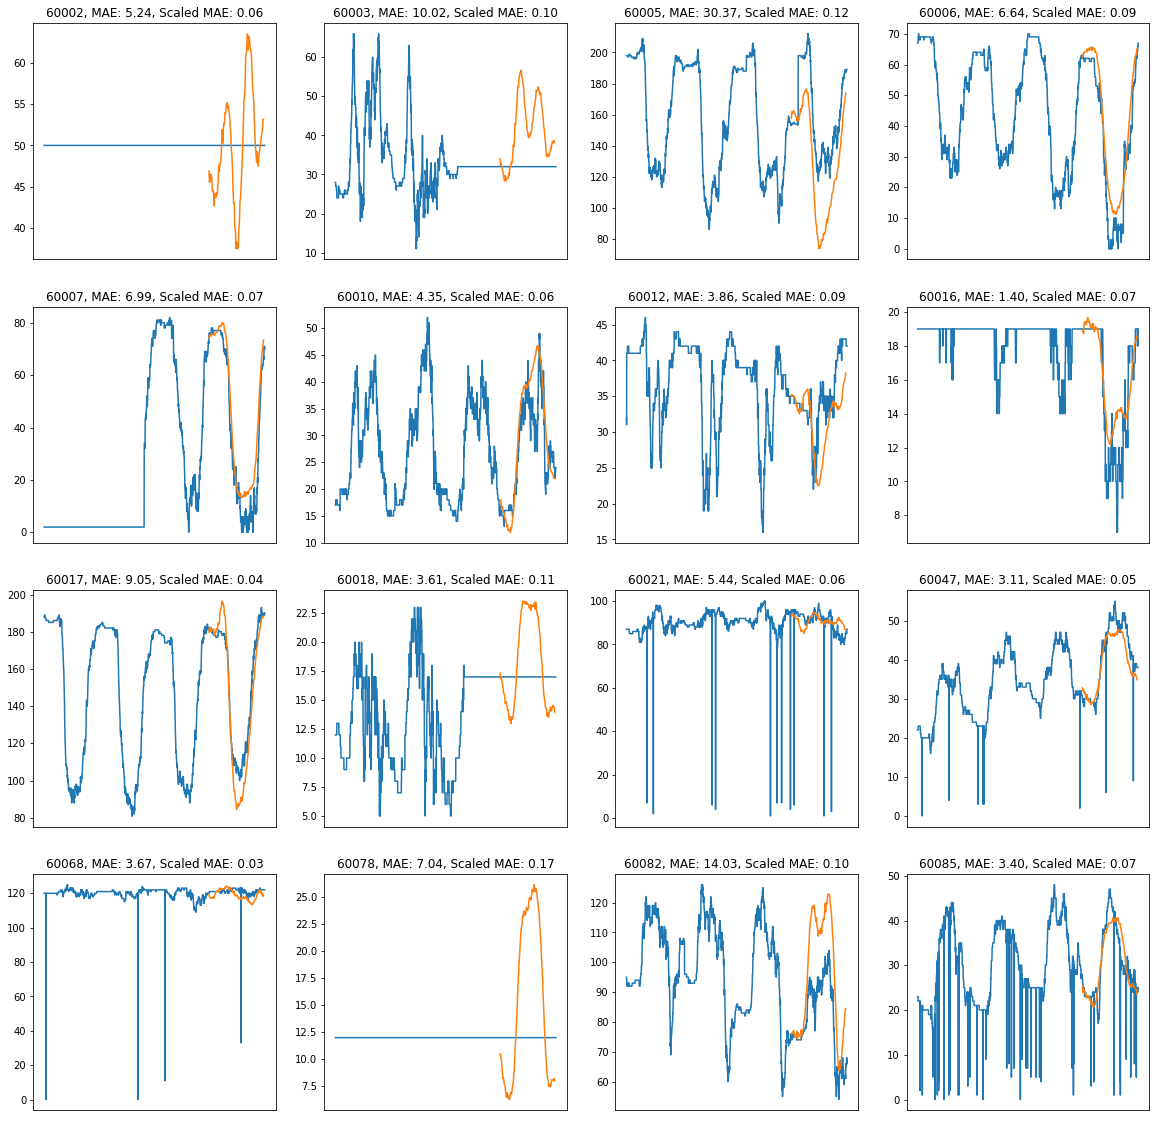

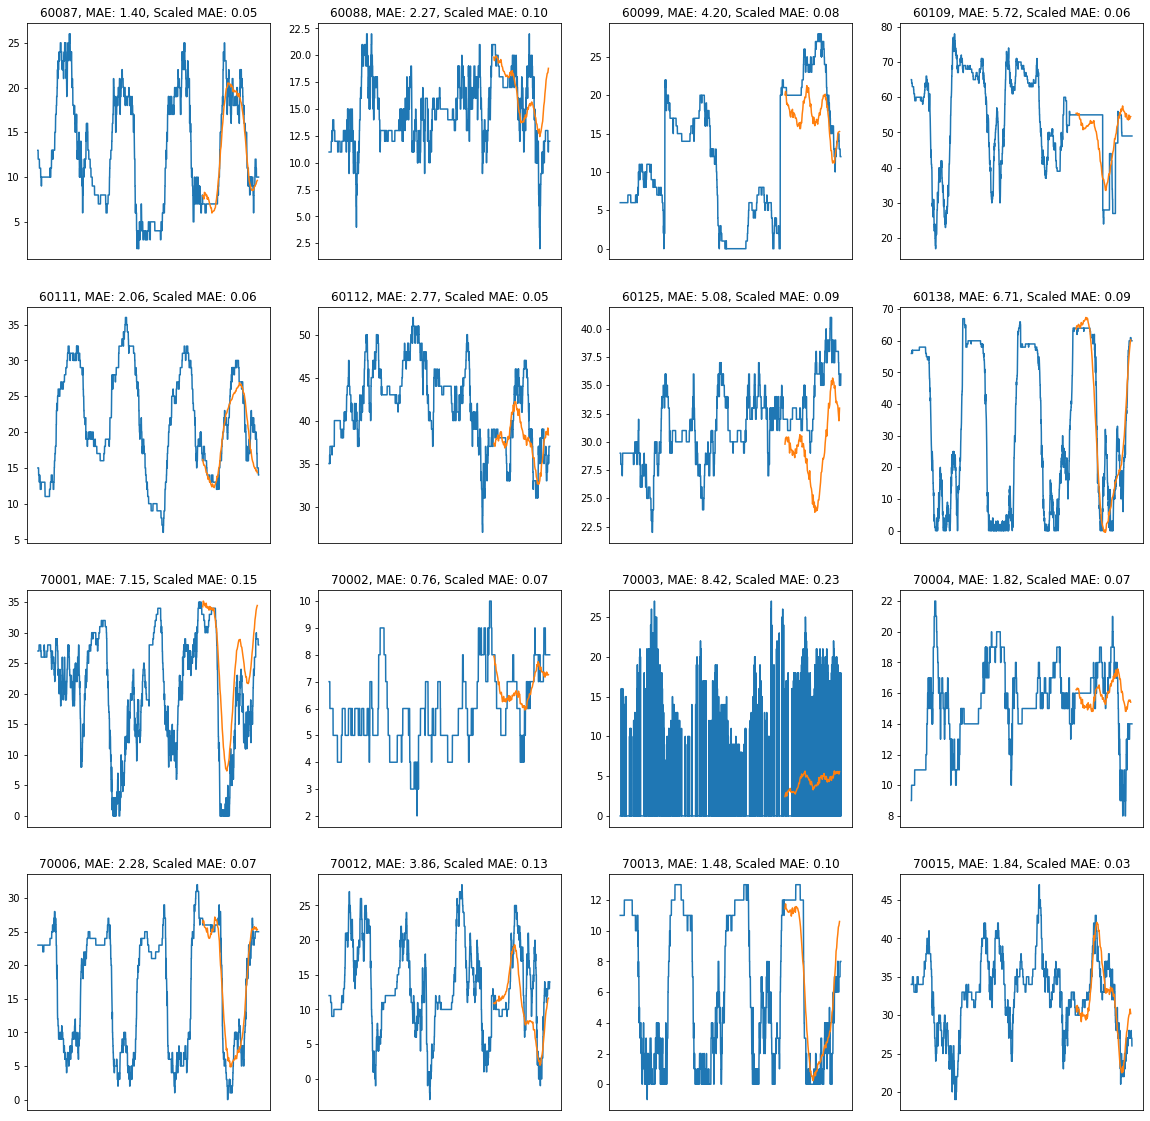

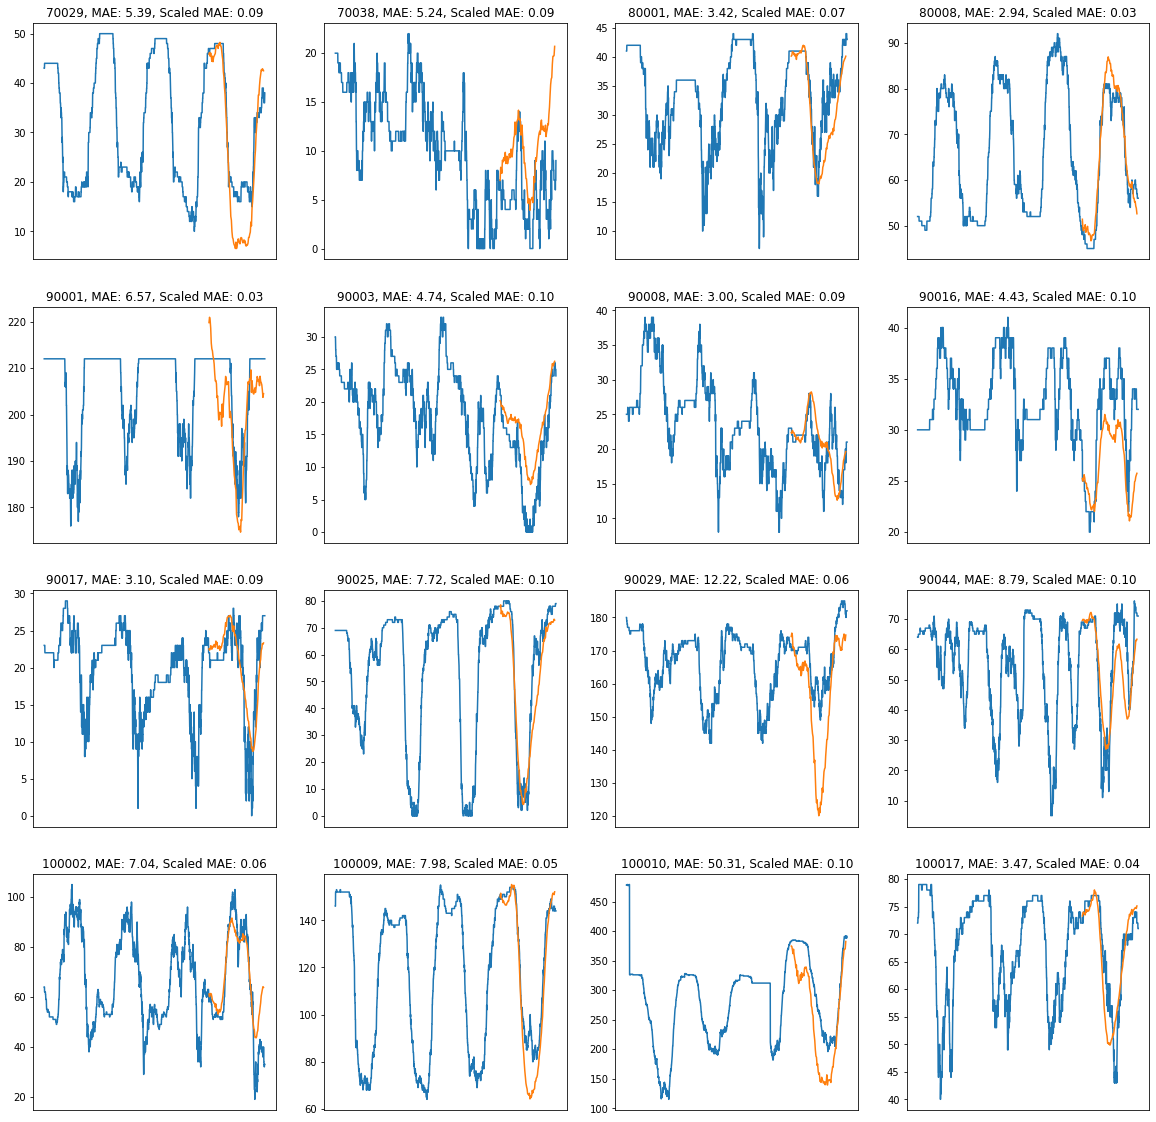

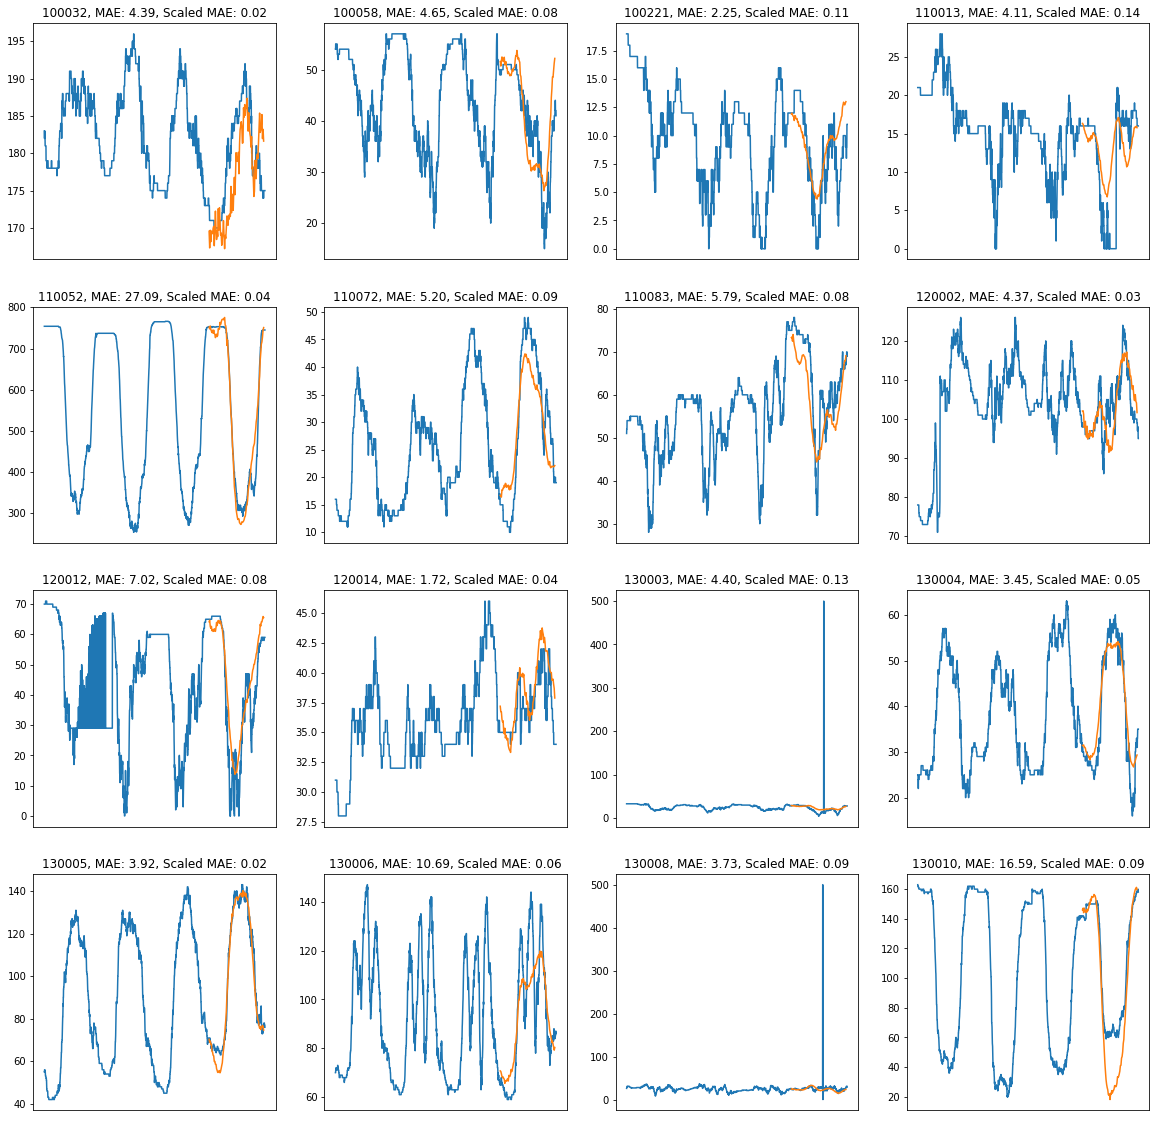

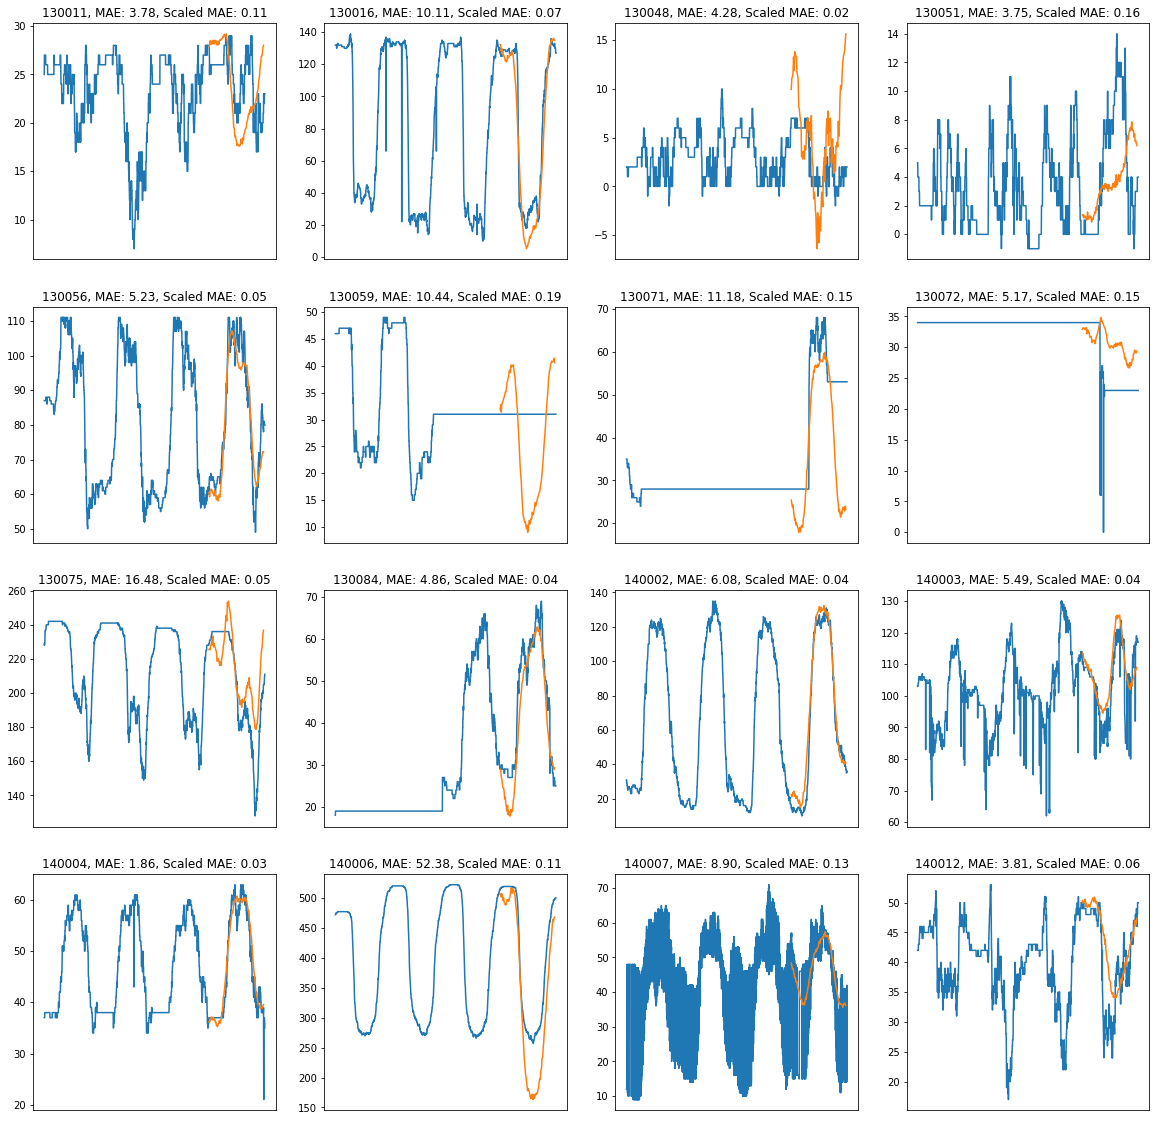

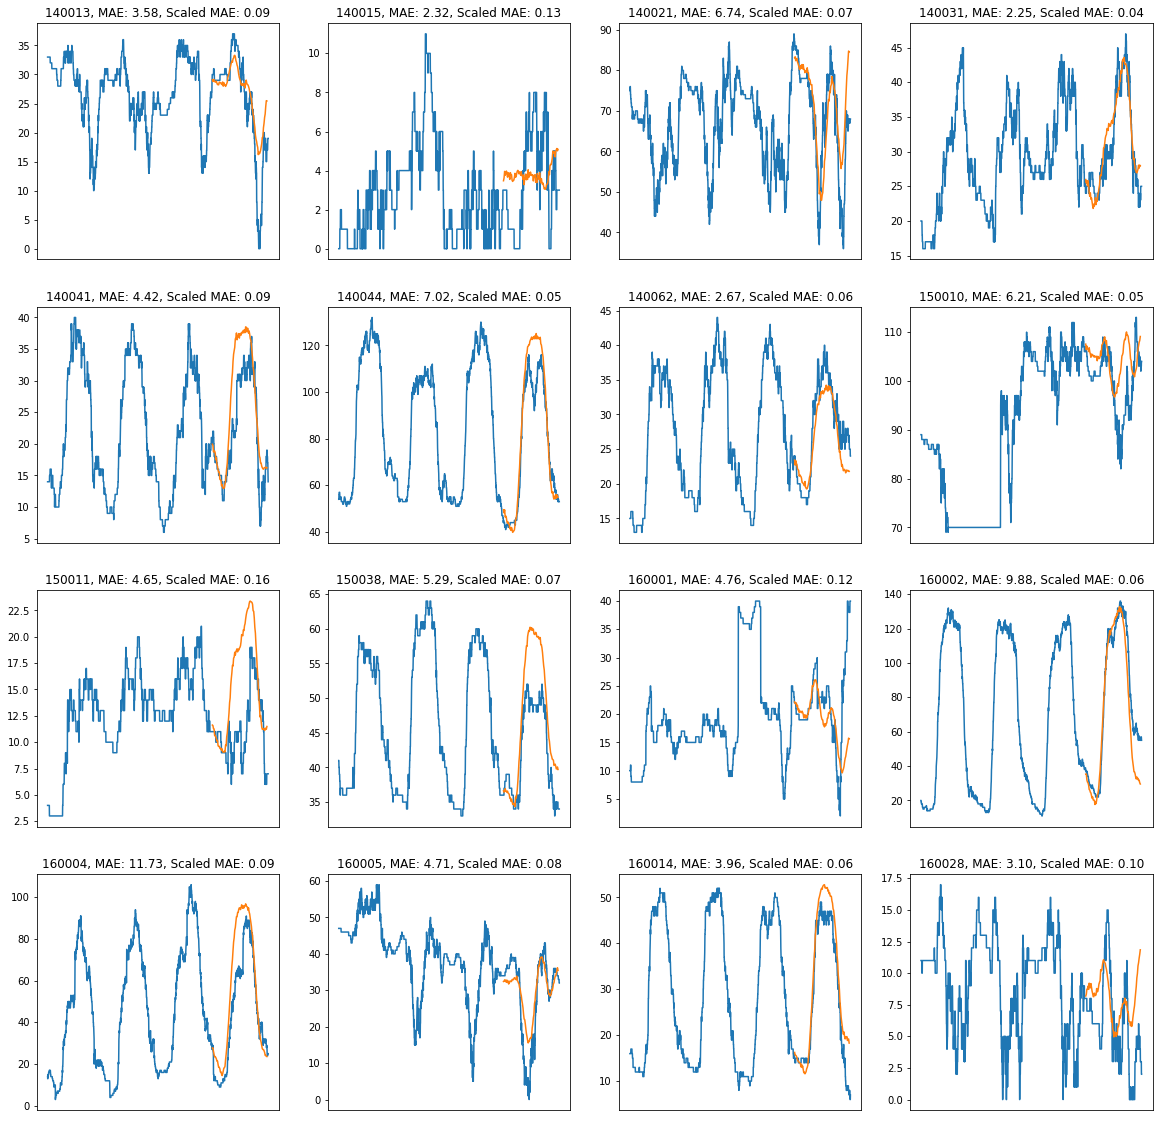

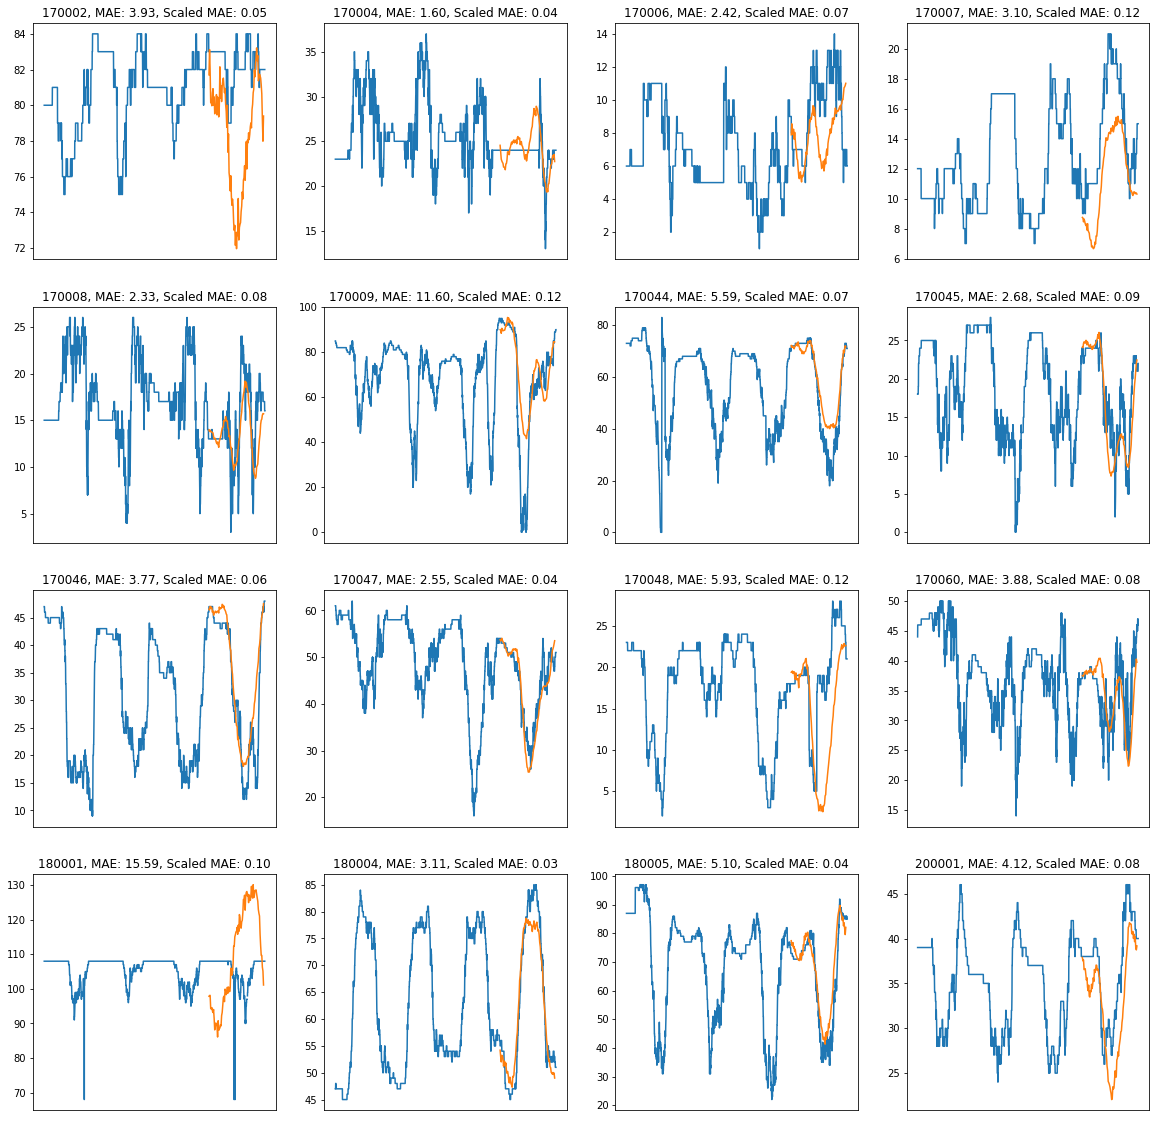

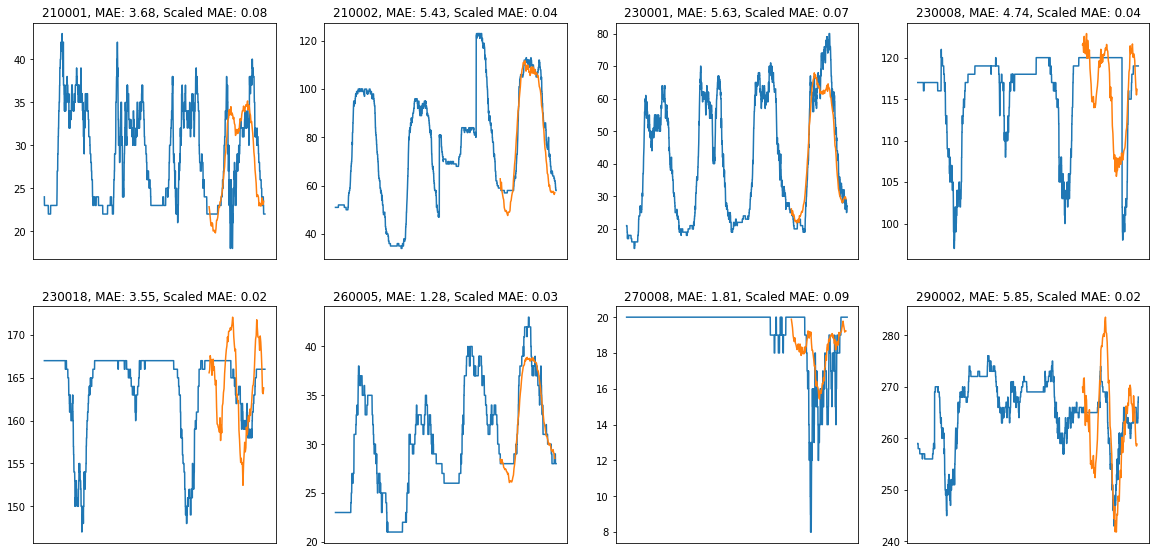

In [ ]:
for i, id in enumerate(ids_eval):
    if i % 16 == 0:
        if i != 0:
            plt.show()
        plt.figure(figsize=(20, 20))
    try:
        ground_truth, pred_df, diff, diff_scaled = get_pred(0)

        plt.subplot(4, 4, i % 16 + 1)
        plt.xticks([], [])
        plt.title(f'{id}, MAE: {abs(diff).mean():.2f}, Scaled MAE: {abs(diff_scaled).mean():.2f}')
        plt.plot(ground_truth)
        plt.plot(pred_df)
    except AssertionError:
        print(f'something went error when processing {id}.')

In [ ]:
all_diff = []
all_diff_scaled = []

for id in tqdm(ids_eval):
    try:
        for start_idx in range(0, test_df.shape[0]-480*4, 5):
            _, _, diff, diff_scaled = get_pred(start_idx)
            all_diff.extend(diff.squeeze().tolist())
            all_diff_scaled.extend(diff_scaled.squeeze().tolist())
    except AssertionError:
        print(f'something went error when processing {id}.')

100%|██████████| 248/248 [35:23<00:00,  8.56s/it]


In [ ]:
all_diff_np = np.array(all_diff)
MAE = np.nanmean(abs(all_diff_np))
MSE = np.nanmean(all_diff_np**2)

all_diff_scaled_np = np.array(all_diff_scaled)
SMAE = np.nanmean(abs(all_diff_scaled_np))
SMSE = np.nanmean(all_diff_scaled_np**2)

print(f'MAE: {MAE}, MSE: {MSE}')
print(f'Scaled MAE: {SMAE}, Scaled MSE: {SMSE}')

MAE: 11.846603684839831, MSE: 748.0445006799649
Scaled MAE: 0.12285819363142016, Scaled MSE: 0.030873550383960884
